In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/cleaned_data.csv")

In [ ]:
df.shape

(489236, 3)

In [ ]:
df.head()

,subject,X-Folder,body
0,Re:,'sent mail,Traveling to have a business meeting takes the...
1,Re: test,'sent mail,test successful. way to go!!!
2,Re: Hello,'sent mail,Let's shoot for Tuesday at 11:45.
3,Re: Hello,'sent mail,"Greg,\n\n How about either next Tuesday or Thu..."
4,Re: PRC review - phone calls,'sent mail,any morning between 10 and 11:30


In [ ]:
file = open("drive/MyDrive/enron.txt", "r", encoding = "utf8")

# store file in list
lines = []
for i in file:
    lines.append(i)

# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines)

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces
data = data.split()
data = ' '.join(data)
data[:500]

'Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary. As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too ofte'

In [ ]:
len(data)

369102

**Tokenizing the Vocabulary**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1790, 4, 24, 8, 354, 104, 1304, 2, 2855, 75, 7, 2, 1036, 1037, 37]

**Number of Unique Words**

In [ ]:
len(sequence_data)

63918

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

6622


In [ ]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)

print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  63915


array([[1790,    4,   24,    8],
       [   4,   24,    8,  354],
       [  24,    8,  354,  104],
       [   8,  354,  104, 1304],
       [ 354,  104, 1304,    2],
       [ 104, 1304,    2, 2855],
       [1304,    2, 2855,   75],
       [   2, 2855,   75,    7],
       [2855,   75,    7,    2],
       [  75,    7,    2, 1036]])

In [ ]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])

X = np.array(X)
y = np.array(y)

In [ ]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[1790    4   24]
 [   4   24    8]
 [  24    8  354]
 [   8  354  104]
 [ 354  104 1304]
 [ 104 1304    2]
 [1304    2 2855]
 [   2 2855   75]
 [2855   75    7]
 [  75    7    2]]
Response:  [   8  354  104 1304    2 2855   75    7    2 1036]


In [ ]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             66220     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 6622)              6628622   
                                                                 
Total params: 19,743,842
Trainable params: 19,743,842
Non-trainable params: 0
_________________________________________________________________


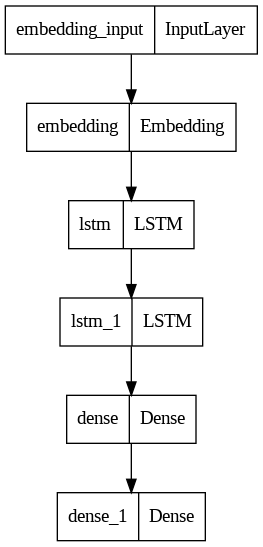

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=35, batch_size=64, callbacks=[checkpoint])

Epoch 1/35
999/999 [==============================] - ETA: 0s - loss: 6.5085
Epoch 1: loss improved from inf to 6.50851, saving model to next_words.h5
999/999 [==============================] - 400s 397ms/step - loss: 6.5085
Epoch 2/35
999/999 [==============================] - ETA: 0s - loss: 5.4546
Epoch 2: loss improved from 6.50851 to 5.45464, saving model to next_words.h5
999/999 [==============================] - 399s 399ms/step - loss: 5.4546
Epoch 3/35
999/999 [==============================] - ETA: 0s - loss: 4.8382
Epoch 3: loss improved from 5.45464 to 4.83816, saving model to next_words.h5
999/999 [==============================] - 399s 400ms/step - loss: 4.8382
Epoch 4/35
999/999 [==============================] - ETA: 0s - loss: 4.3504
Epoch 4: loss improved from 4.83816 to 4.35045, saving model to next_words.h5
999/999 [==============================] - 398s 398ms/step - loss: 4.3504
Epoch 5/35
999/999 [==============================] - ETA: 0s - loss: 3.9110
Epoch 5: lo

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""

  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break

  print(predicted_word)
  return predicted_word

In [ ]:
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed.....")
      break

  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)

          Predict_Next_Words(model, tokenizer, text)

      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: what is it
['what', 'is', 'it']
1/1 [==============================] - 1s 808ms/step
as
Enter your line: this is not
['this', 'is', 'not']
1/1 [==============================] - 0s 25ms/step
lose
Enter your line: it would be
['it', 'would', 'be']
1/1 [==============================] - 0s 36ms/step
likely
Enter your line: way to go
['way', 'to', 'go']
1/1 [==============================] - 0s 33ms/step
let's
Enter your line: 0
Execution completed.....


In [ ]:
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed.....")
      break

  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)

          Predict_Next_Words(model, tokenizer, text)

      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: as discussed we
['as', 'discussed', 'we']
1/1 [==============================] - 1s 1s/step
have
Enter your line: nice to meet
['nice', 'to', 'meet']
1/1 [==============================] - 0s 39ms/step
the
Enter your line: it would be
['it', 'would', 'be']
1/1 [==============================] - 0s 36ms/step
likely
Enter your line: way to go
['way', 'to', 'go']
1/1 [==============================] - 0s 37ms/step
let's
Enter your line: there might be
['there', 'might', 'be']
1/1 [==============================] - 0s 37ms/step
for
Enter your line: might be for
['might', 'be', 'for']
1/1 [==============================] - 0s 35ms/step
the
Enter your line: it is for
['it', 'is', 'for']
1/1 [==============================] - 0s 34ms/step
the
Enter your line: we are going
['we', 'are', 'going']
1/1 [==============================] - 0s 35ms/step
to
Enter your line: lets catch up
['lets', 'catch', 'up']
1/1 [==============================] - 1s 821ms/step
to
Enter your line: l